In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

C:\Users\tlp\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Récupération des données

In [2]:
# Données
df_names = pd.read_csv('data/firstname_with_sex.csv',sep=";")
df_transcriptions = pd.read_csv('data/transcriptions_with_sex.csv')

display(df_names.head())
display(df_transcriptions.head())

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


### Statistiques descritptives

In [3]:
display(df_names.head(5))
print(
    f"""
    Taille de la base : {len(df_names)}, \n
    Nombre de prénoms uniquement masculins : {len(df_names.loc[df_names.female==0])}, \n
    Nombre de prénoms uniquement féminins : {len(df_names.loc[df_names.male==0])}, \n
    """
)

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951



    Taille de la base : 6946, 

    Nombre de prénoms uniquement masculins : 1809, 

    Nombre de prénoms uniquement féminins : 2080, 

    


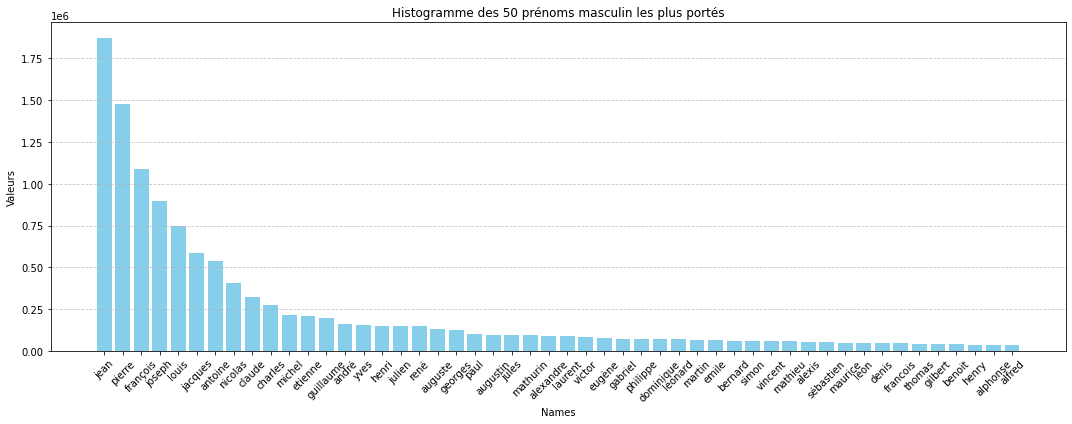

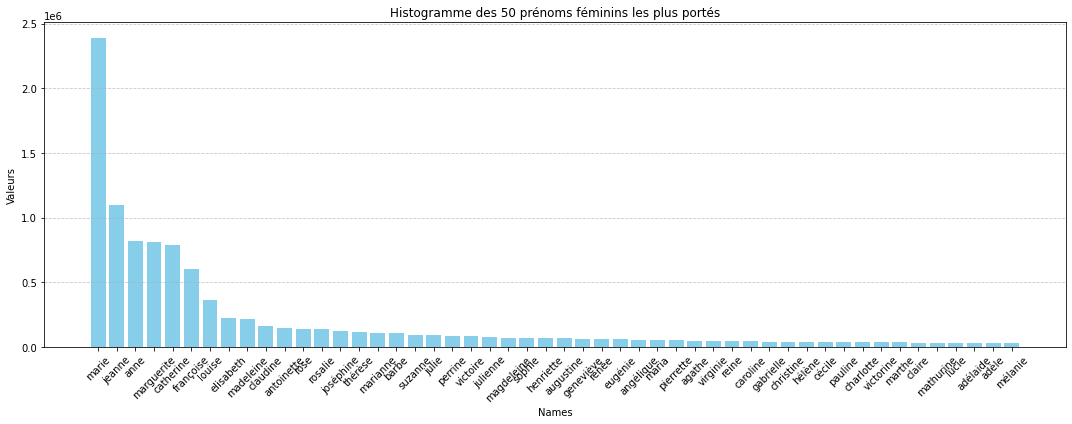

In [4]:
sexes = [['male', "masculin"], ['female', 'féminins']]

for sex, intitule in sexes :
    plt.figure(figsize=(15, 6))
    plt.bar(
        data=df_names.sort_values(by=sex, ascending = False).head(50),
        x="firstname",
        height=sex,
        color='skyblue'
    )
    plt.xlabel('Names')  # Étiquette de l'axe des x
    plt.ylabel('Valeurs')  # Étiquette de l'axe des y
    plt.title(f'Histogramme des 50 prénoms {intitule} les plus portés')  # Titre du graphique
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Activation de la grille avec un style en pointillés
    plt.xticks(rotation=45)
    plt.tight_layout()  # Ajustement automatique de la mise en page
    plt.show()  # Affichage du barplot

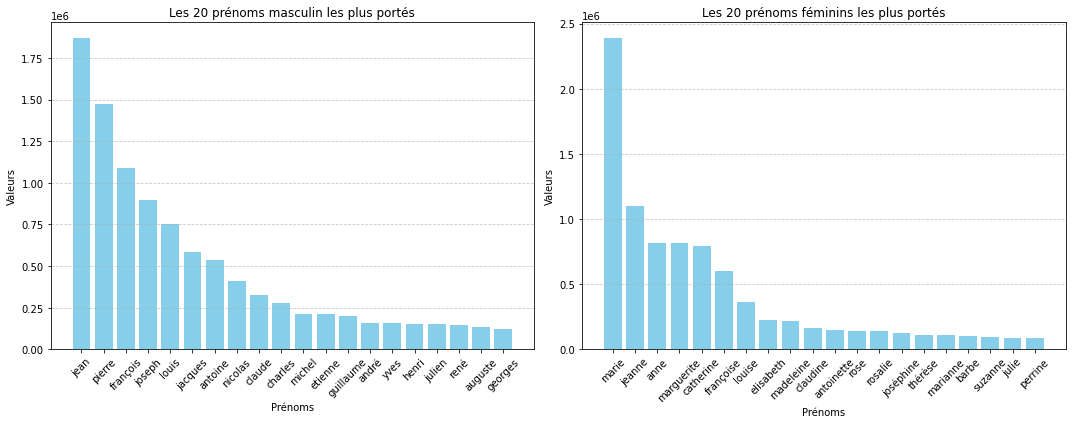

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (sex, intitule) in enumerate(sexes):
    sorted_data = df_names.sort_values(by=sex, ascending=False).head(20)
    axes[i].bar(
        sorted_data['firstname'],
        sorted_data[sex],
        color='skyblue'
    )
    axes[i].set_xlabel('Prénoms')
    axes[i].set_ylabel('Valeurs')
    axes[i].set_title(f'Les 20 prénoms {intitule} les plus portés')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

### Travail sur le table des transcriptions

La table des transcriptions doit être transformée pour pouvoir être utilisée.  
Nous allons chaque information contenue dans les transcriptions manuelles et automatiques et en faire de nouvelles colonnes. 

In [6]:
categories_truth = []
categories_pred = []

for row in range(len(df_transcriptions)):
    ensemble_categories_truth = re.findall(r'(\w+):', df_transcriptions.groundtruth.iloc[row])
    ensemble_categories_pred = re.findall(r'(\w+):', df_transcriptions.prediction.iloc[row])
    for word in ensemble_categories_truth :
        if word not in categories_truth :
            categories_truth.append(word)
    for word in ensemble_categories_pred :
        if word not in categories_pred :
            categories_pred.append(word)
print(
    f"""
    Liste des catégories dans 'groundtruth' :\n{categories_truth}, \n
    Liste des catégories dans 'prediction' :\n{categories_pred}
    """
)

# Fonction pour extraire les valeurs pour chaque catégorie
def extraire_valeur(texte, categorie):
    valeur = None
    if categorie + ':' in texte:
        valeur = texte.split(categorie + ':')[1].split()[0]
    return valeur

for categorie_truth, categorie_pred in zip(categories_truth,categories_pred):
    df_transcriptions[categorie_truth] = df_transcriptions['groundtruth'].apply(lambda x: extraire_valeur(x, categorie_truth))
    df_transcriptions[categorie_pred] = df_transcriptions['prediction'].apply(lambda x: extraire_valeur(x, categorie_pred))

display(df_transcriptions.head())


    Liste des catégories dans 'groundtruth' :
['surname', 'firstname', 'occupation', 'link', 'age', 'employer', 'birth_date', 'lob', 'civil_status', 'observation'], 

    Liste des catégories dans 'prediction' :
['nom', 'prénom', 'date_naissance', 'lieux_naissance', 'employeur', 'relation', 'profession', 'état_civil', 'éducation']
    


,subject_line,groundtruth,prediction,sex,surname,nom,firstname,prénom,occupation,date_naissance,...,age,employeur,employer,relation,birth_date,profession,lob,état_civil,civil_status,éducation
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Chardon,Marie,Marie,idem,30,...,30,None,None,None,None,None,None,None,None,None
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Lhopital,Louis-Jean,Louis,sp,67,...,67,ahef,None,None,None,None,None,None,None,None
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Pyrin,Marie,Marie,idem,55,...,15,None,idem,d,None,None,None,None,None,None
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Lavocat,Marie,Marie,None,1875,...,None,None,None,None,1875,'',Rigny,None,None,None
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Benne,Marguerite,Marguerite,None,78,...,78,None,None,'',None,None,None,None,None,None


In [7]:
# Uniformisation de la table
df = df_transcriptions.loc[df_transcriptions.sex!="ambigu"]\
                      .replace({"homme":0,"femme":1})\
                      [["firstname","occupation","link","sex"]]
#le seul prenom qui n'a pas été retranscript manuellement
df["firstname"] = df.firstname.fillna("eugene")\
                              .apply(lambda prenom: prenom.lower())

df.head()

,firstname,occupation,link,sex
0,marie,idem,fille,1
1,louis-jean,sp,chef,0
2,marie,idem,idem,1
3,marie,None,1,1
4,marguerite,None,None,1


### Prédiction basée sur la fréquence

In [8]:
# Définition des probabilités
df_names['prob_male'] = df_names['male'] / (df_names['male'] + df_names['female'])
df_names['prob_female'] = df_names['female'] / (df_names['male'] + df_names['female'])

df_merged = df.merge(df_names[['firstname','prob_male','prob_female']], on='firstname', how='left')

# Fonction pour prédire le sexe en fonction des probabilités
def predict_row(row):
    prob_male = row['prob_male']
    prob_female = row['prob_female']

    if prob_male > prob_female:
        return 0
    elif prob_female > prob_male:
        return 1
    elif math.isnan(prob_male) :
        return float('nan')
    else:
        return np.random.choice([0, 1])
    
df_merged['predicted_sex'] = df_merged.apply(predict_row, axis=1)
    
df_predicted = df_merged.drop(['prob_male','prob_female'],axis=1)

df_predicted.head()

,firstname,occupation,link,sex,predicted_sex
0,marie,idem,fille,1,1.0
1,louis-jean,sp,chef,0,NaN
2,marie,idem,idem,1,1.0
3,marie,None,1,1,1.0
4,marguerite,None,None,1,1.0


In [9]:
# Extraire les colonnes sexe et sexe_pred
sexe_reel = df_predicted[['sex','predicted_sex']].dropna()['sex'].astype(int)
sexe_pred = df_predicted[['sex','predicted_sex']].dropna()['predicted_sex'].astype(int)

erreur = mean_absolute_error(sexe_reel, sexe_pred)
accuracy = accuracy_score(sexe_reel, sexe_pred)
f1 = f1_score(sexe_reel, sexe_pred, average='macro')

# Afficher les résultats
print(f"Erreur (MAE) : {erreur:.2f}")
print(f"Accuracy : {accuracy:.2f}")
print(f"F1-score : {f1:.2f}")

Erreur (MAE) : 0.00
Accuracy : 1.00
F1-score : 1.00


Il reste 8 prénoms qu'on n'a pas réussi à prédire

In [10]:
df_predicted.loc[df_predicted.predicted_sex.isna()]

,firstname,occupation,link,sex,predicted_sex
1,louis-jean,sp,chef,0,NaN
51,anroine,idem,Fils,0,NaN
60,jean-marie,domestique,domestique,0,NaN
99,jean-marie,idem,fils,0,NaN
118,branislav,manoeuvre,frère,0,NaN
197,jean-baptiste,tourneur,chef,0,NaN
203,jean-claude,idem,idem,0,NaN
221,marie-louise,idem,fille,1,NaN


### Cas général 

In [11]:
# Pour ne pas modifier le dataset initial
df_work = df_names.copy()
df_work["sex"] = df_work.apply(predict_row, axis=1)

### Prépatation de la table
# Ajout des colonnes pour les lettres
df_work['last_letter'] = df_work['firstname'].apply(lambda prenom: prenom[-1])
df_work['2l_letters'] = df_work['firstname'].apply(lambda prenom: prenom[-2:])
df_work['3l_letter'] = df_work['firstname'].apply(lambda prenom: prenom[-3:])

# On drop les colonnes inutiles
df_work=df_work.drop(columns=['firstname',"male","female","prob_male","prob_female"])

# On transforme les dernières lettres en indicatrices
df_work = pd.get_dummies(df_work, columns=['3l_letter','2l_letters','last_letter'])

### Prépatation des dataset d'entrainement et de test
X = df_work.drop(columns=['sex'])
y = df_work['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Definition des modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Multimodal Bayes' : MultinomialNB()
}

# Liste de résultats
results = []

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    results.append((model_name, mean_cv_score))
    
    print(f"{model_name}: Moyenne de cross-validation: {mean_cv_score:.2f}")
    
    # Modèle
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"{model_name}: \n {classification_report(y_test,y_pred)}")
        

results.sort(key=lambda x: x[1], reverse=True)

for model_name, mean_cv_score in results:
    print(f"{model_name}: Moyenne de cross-validation: {round(mean_cv_score,2)}")

Logistic Regression: Moyenne de cross-validation: 0.87
Logistic Regression: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       672
           1       0.87      0.89      0.88       718

    accuracy                           0.88      1390
   macro avg       0.88      0.88      0.88      1390
weighted avg       0.88      0.88      0.88      1390

Random Forest: Moyenne de cross-validation: 0.86
Random Forest: 
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       672
           1       0.86      0.90      0.88       718

    accuracy                           0.87      1390
   macro avg       0.87      0.87      0.87      1390
weighted avg       0.87      0.87      0.87      1390

Naive Bayes: Moyenne de cross-validation: 0.79
Naive Bayes: 
               precision    recall  f1-score   support

           0       0.94      0.64      0.76       672
           1       0.74      0.